# Supervised ML - classify stars, quasars, and galaxies

In [1]:
# Analyses based on paper: Clarke, A. O., Scaife, A. M. M., Greenhalgh, R. & Griguta, V. (2020). Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra. Astronomy & Astrophysics, 639, A84. https://doi.org/10.1051/0004-6361/201936770
# ChatGPT assistance: https://chatgpt.com/share/686c0b5f-d574-8011-af1f-8f6fa392d3d3

In [1]:
# ------------------------------------------------------------
# 1a. Mount Google Drive (do this once per Colab session)
# ------------------------------------------------------------
import pickle
from google.colab import drive
drive.mount('/content/drive/')
googledrive_path = "drive/MyDrive/AI-in-physics_AJP_2025/Stars Galaxies Quasars/" # This path needs to be appended to the paths, if you load it from Google drive

ModuleNotFoundError: No module named 'google'

In [ ]:
# ------------------------------------------------------------
# 1b. If you are on a local machine, set dir to current working tree
# ------------------------------------------------------------
import pickle
googledrive_path = '../Stars Galaxies Quasars/' # needs to be adapted to specific context

In [3]:
# ------------------------------------------------------------
# 1c. If you use the binder version
# ------------------------------------------------------------
googledrive_path = '' # needs to be adapted to specific context

In [5]:
# load relevant packages:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import hdbscan

import numpy as np
import pickle
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# load data:
(tsne_subsample,tsne_subsample_classes) = pickle.load( open( googledrive_path + "Dataset_galaxies_quasars_stars/subdf_unsupervised.pickle", "rb" ))

ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
import numpy as np
print( np.unique( tsne_subsample_classes ))
for o in ['STAR','GALAXY','QSO']:
    print( o )
    print( np.round( tsne_subsample[ np.where(tsne_subsample_classes==o)[0][:2] ], 3 ) )

['GALAXY' 'QSO' 'STAR']
STAR
[[2.1529e+01 1.8571e+01 1.7199e+01 1.6525e+01 1.6147e+01 1.4014e+01
  1.4036e+01 1.3286e+01 9.1180e+00 3.0000e-03]
 [1.9190e+01 1.7982e+01 1.7467e+01 1.7235e+01 1.7123e+01 1.5295e+01
  1.5094e+01 1.2837e+01 9.1740e+00 5.0000e-03]]
GALAXY
[[21.36  20.022 19.495 19.128 18.878 14.604 14.425 11.079  8.945  2.411]
 [22.783 22.479 21.295 20.391 22.827 13.546 13.588 11.999  9.046  0.628]]
QSO
[[2.0617e+01 2.0084e+01 2.0109e+01 2.0126e+01 1.9884e+01 1.7075e+01
  1.5981e+01 1.3118e+01 8.8840e+00 1.4000e-02]
 [1.9939e+01 1.9849e+01 1.9543e+01 1.9615e+01 1.9629e+01 1.5371e+01
  1.4206e+01 1.1351e+01 9.3030e+00 7.0000e-03]]


In [ ]:
# code genertated with ChatGPT (GPT4, Version 25 May 2023)

# Splitting the dataset into train and test
# (set random_state to make split reproducible)
X_train, X_test, y_train, y_test = train_test_split(tsne_subsample,
                                                    tsne_subsample_classes,
                                                    test_size=0.4,
                                                    random_state=42)

# generate test and validation:
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    test_size=0.5,
                                                    random_state=42)

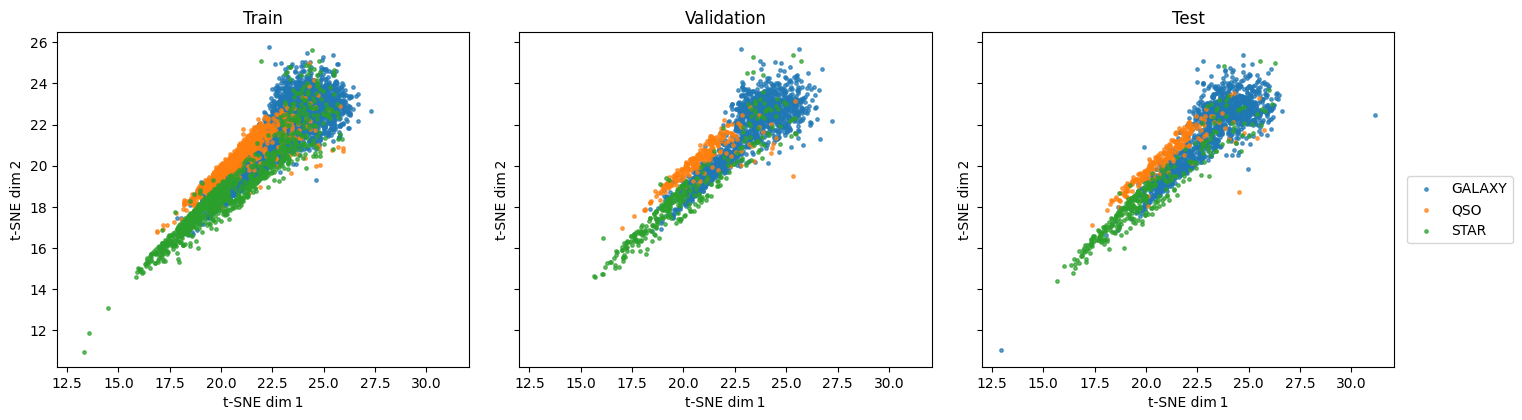

In [ ]:
# Pick two dimensions to display (here: first two)
def to_xy(arr):
    return arr[:, 0], arr[:, 1]

# Consistent colors per class
unique_classes = np.unique(tsne_subsample_classes)
colors = dict(zip(unique_classes, ['tab:blue', 'tab:orange', 'tab:green']))  # adjust if you like

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

splits = [
    ("Train",  X_train, y_train, axes[0]),
    ("Validation", X_val, y_val, axes[1]),
    ("Test",   X_test,  y_test, axes[2])
]

for title, X, y, ax in splits:
    for cls in unique_classes:
        x, y_coord = to_xy(X[y == cls])
        ax.scatter(x, y_coord, s=6, alpha=0.7, label=cls,
                   color=colors[cls])
    ax.set_title(title)
    ax.set_xlabel("t‑SNE dim 1")
    ax.set_ylabel("t‑SNE dim 2")
    ax.set_aspect('equal')

# Only one legend, outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.02, 0.5))
fig.tight_layout(rect=[0, 0, 0.95, 1])  # squeeze room for legend
plt.savefig(googledrive_path + 'train-val-test_Starsdata.png', dpi=300, bbox_inches="tight")
plt.show()

Accuracy
  Train: 1.000
  Val  : 0.977
  Test : 0.968

— Classification report on the test set —
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98      1444
         QSO       0.91      0.91      0.91       240
        STAR       0.98      0.93      0.95       316

    accuracy                           0.97      2000
   macro avg       0.95      0.94      0.95      2000
weighted avg       0.97      0.97      0.97      2000



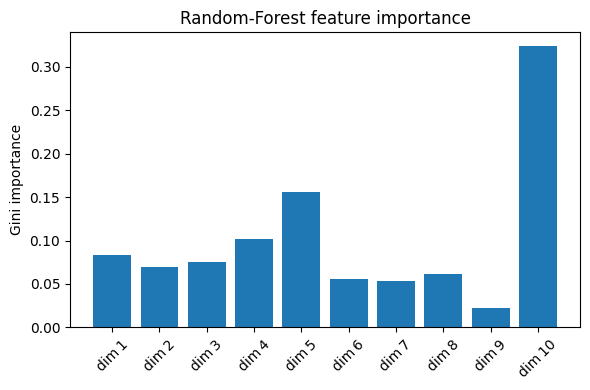

In [ ]:
# Random‑Forest fit + metrics + feature‑importance plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Fit ------------------------------------------------------------
rf = RandomForestClassifier(
        n_estimators=300,          # plenty of trees for stability
        max_depth=None,            # let each tree grow fully
        random_state=42,
        n_jobs=-1,                 # use all cores
        class_weight='balanced'    # good if the three classes are uneven
)
rf.fit(X_train, y_train)

# --- 2. “Fit values” = performance on each split -----------------------
pred_train = rf.predict(X_train)
pred_val   = rf.predict(X_val)
pred_test  = rf.predict(X_test)

print("Accuracy")
print(f"  Train: {accuracy_score(y_train, pred_train):.3f}")
print(f"  Val  : {accuracy_score(y_val,   pred_val ):.3f}")
print(f"  Test : {accuracy_score(y_test,  pred_test):.3f}")

print("\n— Classification report on the test set —")
print(classification_report(y_test, pred_test))

# --- 3. Feature importance ---------------------------------------------
importances = rf.feature_importances_
feature_names = [f"dim {idx+1}" for idx in range(X_train.shape[1])]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(importances)), importances, tick_label=feature_names)
ax.set_ylabel("Gini importance")
ax.set_title("Random‑Forest feature importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()